In [759]:
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.constants import h, c, k
from radis import sPlanck
from astropy.constants import R_sun

In [760]:
u_filter = pd.read_csv('Paranal_VIMOS.U.dat', sep=' ', header=None)
b_filter = pd.read_csv('Paranal_VIMOS.B.dat', sep=' ', header=None)
v_filter = pd.read_csv('Paranal_VIMOS.V.dat', sep=' ', header=None)
r_filter = pd.read_csv('Paranal_VIMOS.R.dat', sep=' ', header=None)
i_filter = pd.read_csv('Paranal_VIMOS.I.dat', sep=' ', header=None)

filtros = {'U': u_filter, 'B': b_filter, 'V': v_filter, 'R': r_filter, 'I': i_filter}

In [761]:
# Renombro las columnas 
for key in filtros:
    filtros[key].columns = ['Wavelength', 'Transmission']

# 1.a)

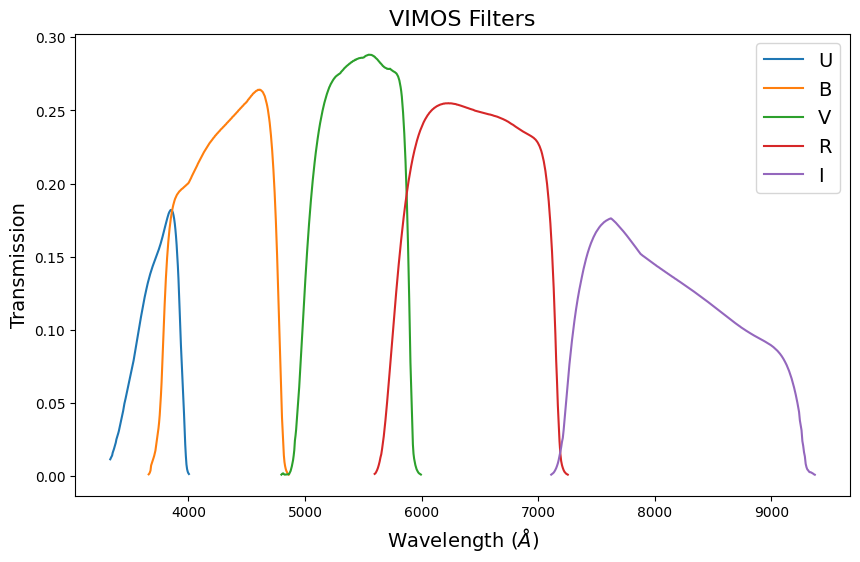

In [762]:
fig, ax = plt.subplots(figsize=(10, 6))
for key in filtros:
    ax.plot(filtros[key]['Wavelength'], filtros[key]['Transmission'], label=key)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Transmission', fontsize=14)
ax.set_title('VIMOS Filters', fontsize=16)
ax.legend(fontsize=14)

In [763]:
for key in filtros:
    filtros[key]['Transmission normalized'] = filtros[key]['Transmission'] / filtros[key]['Transmission'].max()

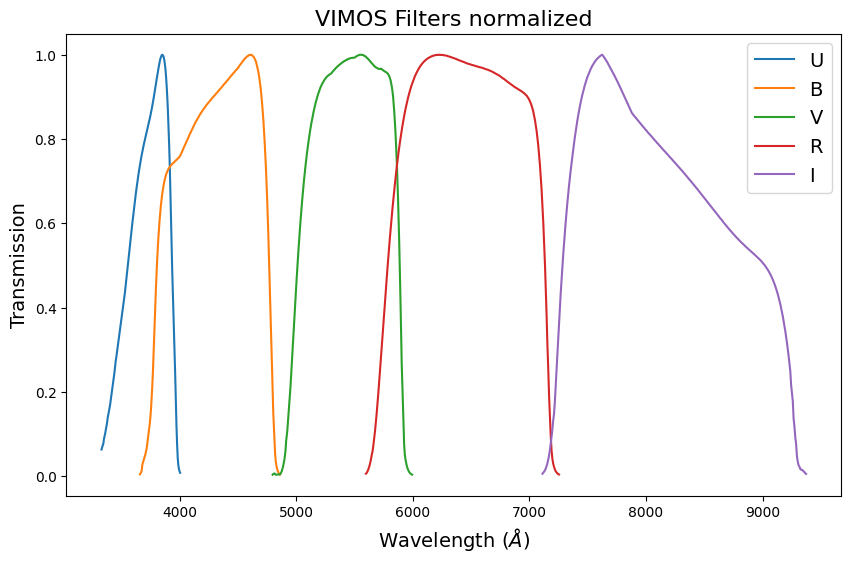

In [764]:
fig, ax = plt.subplots(figsize=(10, 6))
for key in filtros:
    ax.plot(filtros[key]['Wavelength'], filtros[key]['Transmission normalized'], label=key)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Transmission', fontsize=14)
ax.set_title('VIMOS Filters normalized', fontsize=16)
ax.legend(fontsize=14)

### -> Según el sistema fotométrico Johnson-Cousins las longitudes de onda (en Angstrom) efectivas de cada filtro son U: 3720.47, B: 4304.32, V:  5450.23, R: 6449.68, I: 8129.05, lo cual a simple vista se puede ver que calzan con las longitudes efectivos de los filtros del sistema Johnson-Cousins. Por otro lado queremos ver el rango de longitud de onda en el cual están actuando, siendo estas $\Delta \lambda_U$= 672.09, $\Delta\lambda_B$= 1176.36, $\Delta\lambda_V$= 1097.02, $\Delta\lambda_R$= 1622.72, $\Delta\lambda_I$= 2235.51, estos valores son parecidos para los filtros U y R, pero los demás están más alejados del rango.

    Banda, Lambda eff, rango
    U:     3663         650

    B:     4361         890

    V:     5448         840

    R:     6407         1580

    I:     7980         1540

In [765]:
data = pd.read_excel('C:/Users/rodri\Desktop/astrofis/t1/e490_00a_amo.xls')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
W_wavelength_microns = data['Wavelength, µm']
W_flux_microns = data['Wehrli, W/m2/µm']

# Quitar los valores de nan
W_wavelength_microns = W_wavelength_microns.dropna()
W_flux_microns = W_flux_microns.dropna()


W_wavelength_angstroms = (np.array(W_wavelength_microns)*u.micron).to(u.angstrom)
W_flux_ergs = (np.array(W_flux_microns)*(u.watt / u.m**2 / u.micron)).to(u.erg / u.s / u.cm**2 / u.angstrom)
solar_spectrum = pd.DataFrame({'Wavelength': W_wavelength_angstroms, 'Flux': W_flux_ergs})

In [766]:
def band_fit(band):
    poli_fit = np.polyfit(band['Wavelength'], band['Transmission'], 15)
    poli = np.poly1d(poli_fit)
    x_new = np.linspace(band['Wavelength'].min(), band['Wavelength'].max(), 10000)
    y_new = poli(x_new)
    return pd.DataFrame({'Wavelength': x_new, 'Transmission': y_new})

In [767]:
fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}

C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\1781603112.py:1: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}
C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\1781603112.py:1: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}
C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\1781603112.py:1: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}
C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\1781603112.py:1: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_f

In [768]:
solar_spectrum['Wavelength'] = solar_spectrum['Wavelength'].astype(int)

for key in fits:
    fits[key]['Wavelength'] = fits[key]['Wavelength'].astype(int)
    fits[key].drop_duplicates(subset=['Wavelength'])

    fits[key] = fits[key][fits[key]['Wavelength'].isin(solar_spectrum['Wavelength'])]

In [769]:
for key in fits.keys():
    merged_df = fits[key].merge(solar_spectrum, on='Wavelength', how='inner')
    merged_df['Flux solar'] = merged_df['Flux'] * merged_df['Transmission']
    fits[key] = merged_df
 
for key in fits:
    fits[key]['Total flux'] = fits[key]['Flux solar'].sum()

# 1.b)

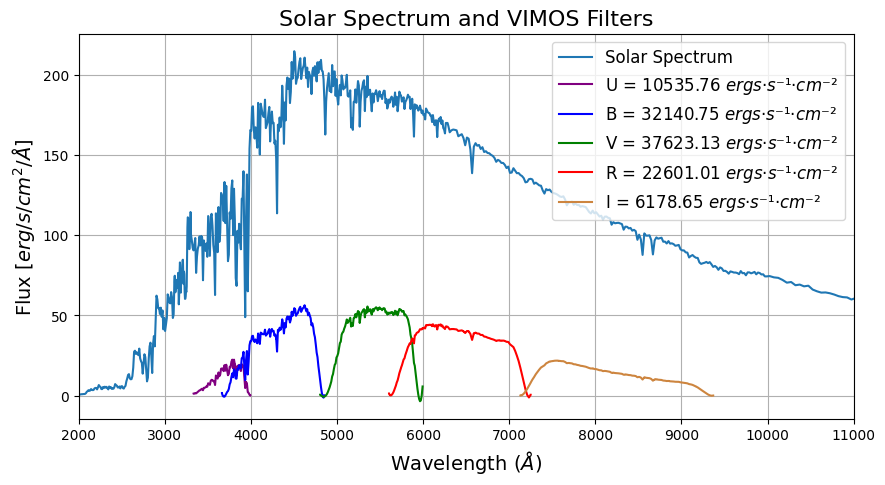

In [770]:
colors = ['purple', 'blue', 'green', 'red', 'peru']
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(solar_spectrum['Wavelength'], solar_spectrum['Flux'], label=f'Solar Spectrum')
for key, color in zip(fits, colors):
    ax.plot(fits[key]['Wavelength'], fits[key]['Flux solar'], c=color, label=f'{key} = {fits[key]["Total flux"].values[0]:.2f} $ergs\u00B7s\u207B\u00B9\u00B7cm\u207B\u00B2$')
ax.set_xlim(2000, 11000)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Flux [$erg/s/cm^2/\AA$]', fontsize=14)
ax.set_title('Solar Spectrum and VIMOS Filters', fontsize=16)
ax.grid()
ax.legend(fontsize=12)

### -> A simple vista somos capaces de descartar los filtros U e I debido a la poca contribución de flujo que sumarían siguiendo el espectro del sol, por lo que resta decidir entre B, V o R quién recibe más flujo, y eso lo conseguimos a través de obtener el flujo total captado por los filtros, por lo que el filtro V es el que parece más brillante.

# 1.C

In [771]:
def espectro(T, wavelengths):
    h = 6.62607004e-34  # Constante de Planck, en m^2 kg / s
    c = 3e8  # Velocidad de la luz, en m / s
    k = 1.38064852e-23  # Constante de Boltzmann, en m^2 kg s^-2 K^-1

    def planck(wl, T):
        """ Función de Planck para obtener la densidad de energía espectral. """
        a = 2.0*h*c**2
        b = h*c/(wl*k*T)
        intensity = a/ ((wl**5) * (np.exp(b) - 1.0))
        return intensity

    # Calculamos la densidad de energía espectral
    intensity = planck(wavelengths, T)

    wavelengths_nm = (wavelengths * 1e9) * u.nm  # Convertimos a nm
    intensity_Wm2nm = (intensity * 1e-9) * u.W / u.m**2 / u.nm  # Convertimos a W / m^2 / nm

    wavelengths_armstrong  = (wavelengths_nm.to(u.angstrom)) # Convertimos a Armstrong
    intensity_ergs = (intensity_Wm2nm.to(u.erg / u.s / u.cm**2 / u.angstrom)) # Convertimos a erg / s / cm^2 / Armstrong

    return pd.DataFrame({'Wavelength': wavelengths_armstrong, 'Flux': intensity_ergs})

In [772]:
def observed_flux(spectrum, r, d):
    spectrum['Flux'] = spectrum['Flux'] * ((r*R_sun)/(d*u.lightyear.to(u.m)))**2

In [773]:
def aplicar_filtro(spectrum):
    spectrum['Wavelength'] = spectrum['Wavelength'].astype(int)
    u_filter = pd.read_csv('Paranal_VIMOS.U.dat', sep=' ', header=None)
    b_filter = pd.read_csv('Paranal_VIMOS.B.dat', sep=' ', header=None)
    v_filter = pd.read_csv('Paranal_VIMOS.V.dat', sep=' ', header=None)
    r_filter = pd.read_csv('Paranal_VIMOS.R.dat', sep=' ', header=None)
    i_filter = pd.read_csv('Paranal_VIMOS.I.dat', sep=' ', header=None)

    filtros = {'U': u_filter, 'B': b_filter, 'V': v_filter, 'R': r_filter, 'I': i_filter}

    for key in filtros:
        filtros[key].columns = ['Wavelength', 'Transmission']

    fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}

    for key in fits:
        fits[key]['Wavelength'] = fits[key]['Wavelength'].astype(int)
        fits[key].drop_duplicates(subset=['Wavelength'])

        fits[key] = fits[key][fits[key]['Wavelength'].isin(spectrum['Wavelength'])]
    
    for key in fits.keys():
        merged_df1 = fits[key].merge(spectrum, on='Wavelength', how='inner')
        merged_df1['Flux solar'] = merged_df1['Flux'] * merged_df1['Transmission']
        fits[key] = merged_df1

    for key in fits:
        fits[key]['Total flux'] = fits[key]['Flux solar'].sum()

    for key in fits:
        fits[key]['flux integrated'] = np.trapz(fits[key]['Flux solar'], fits[key]['Wavelength'])

    for key in fits:
        fits[key]['fs'] = np.trapz(fits[key]['Flux solar'], fits[key]['Wavelength']) / np.trapz(fits[key]['Transmission'], fits[key]['Wavelength'])

    return fits

In [774]:
mira_spectrum = espectro(3000, np.linspace(1e-9, 4e-6, 100000))
rigel_spectrum = espectro(11000, np.linspace(1e-9, 4e-6, 10000))
saif_spectrum = espectro(32500, np.linspace(1e-9, 4e-6, 10000))
naos_spectrum = espectro(42000, np.linspace(1e-9, 4e-6, 10000))

C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\1290640516.py:10: RuntimeWarning: overflow encountered in exp
  intensity = a/ ((wl**5) * (np.exp(b) - 1.0))


In [775]:
observed_flux(mira_spectrum, 302, 418)
observed_flux(rigel_spectrum, 860, 74)
observed_flux(saif_spectrum, 13000, 8.3)
observed_flux(naos_spectrum, 900, 14)

In [776]:
mira_filtro = aplicar_filtro(mira_spectrum)
rigel_filtro = aplicar_filtro(rigel_spectrum)
saif_filtro = aplicar_filtro(saif_spectrum)
naos_filtro = aplicar_filtro(naos_spectrum)

C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\3703379534.py:14: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}
C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\3703379534.py:14: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}
C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\3703379534.py:14: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': band_fit(filtros['V']), 'R': band_fit(filtros['R']), 'I': band_fit(filtros['I'])}
C:\Users\rodri\AppData\Local\Temp\ipykernel_10236\3703379534.py:14: RankWarning: Polyfit may be poorly conditioned
  fits = {'U': band_fit(filtros['U']), 'B': band_fit(filtros['B']), 'V': ba

Text(0.5, 1.0, 'Mira Spectrum and VIMOS Filters')

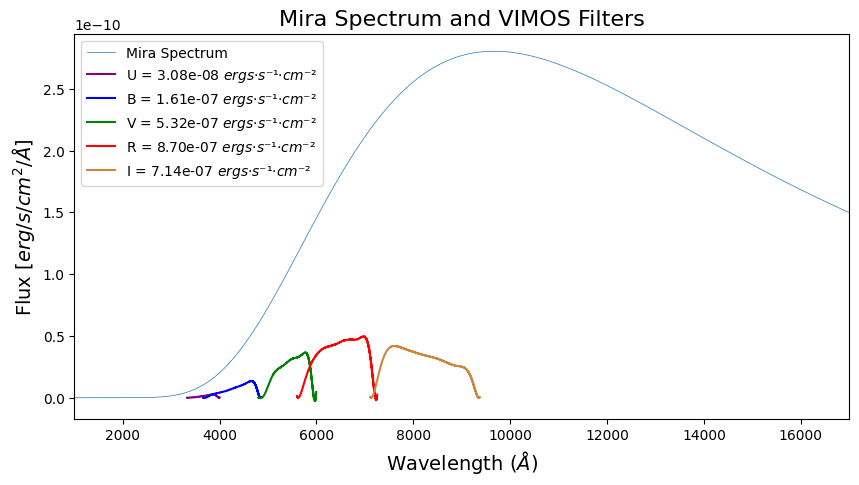

In [777]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mira_spectrum['Wavelength'], mira_spectrum['Flux'], label=f'Mira Spectrum', linewidth=0.5)
for key, color in zip(mira_filtro, colors):
    ax.plot(mira_filtro[key]['Wavelength'], mira_filtro[key]['Flux solar'], c=color, label=f'{key} = {mira_filtro[key]["Total flux"].values[0]:.2e} $ergs\u00B7s\u207B\u00B9\u00B7cm\u207B\u00B2$')
ax.set_xlim(1000, 17000)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Flux [$erg/s/cm^2/\AA$]', fontsize=14)
ax.legend()
ax.set_title('Mira Spectrum and VIMOS Filters', fontsize=16)

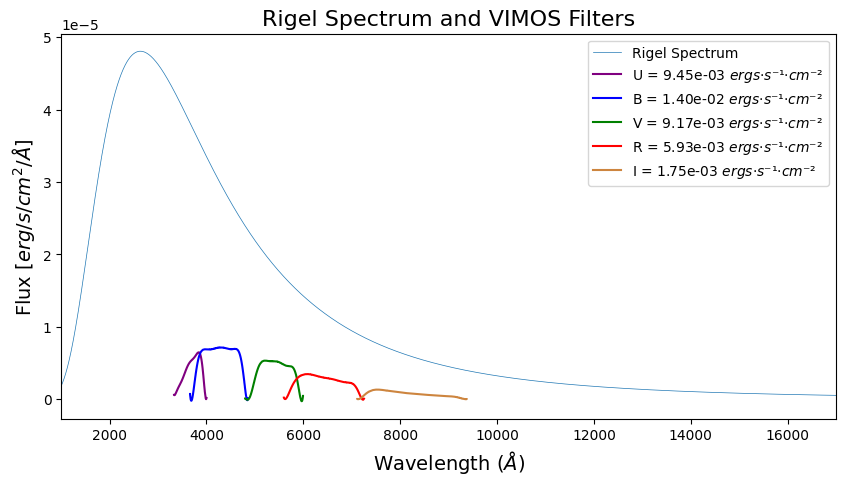

In [778]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rigel_spectrum['Wavelength'], rigel_spectrum['Flux'], label=f'Rigel Spectrum', linewidth=0.5)
for key, color in zip(rigel_filtro, colors):
    ax.plot(rigel_filtro[key]['Wavelength'], rigel_filtro[key]['Flux solar'], c=color, label=f'{key} = {rigel_filtro[key]["Total flux"].values[0]:.2e} $ergs\u00B7s\u207B\u00B9\u00B7cm\u207B\u00B2$')
ax.set_xlim(1000, 17000)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Flux [$erg/s/cm^2/\AA$]', fontsize=14)
ax.set_title('Rigel Spectrum and VIMOS Filters', fontsize=16)
ax.legend()

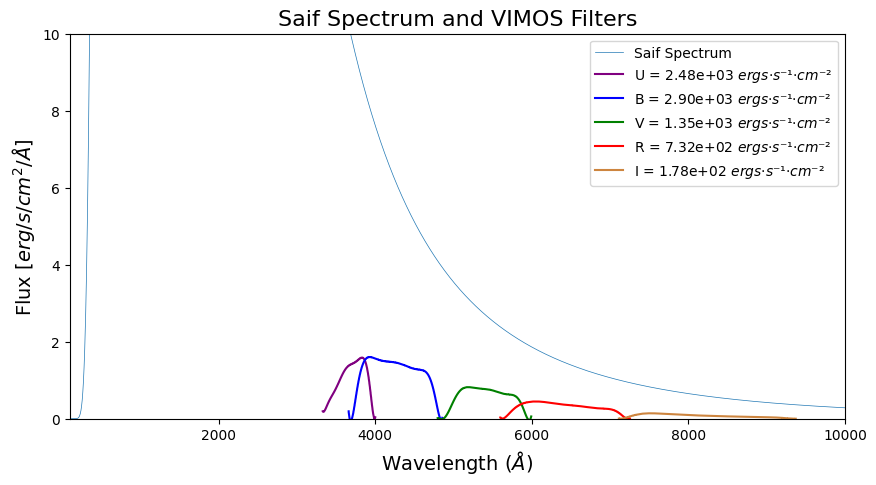

In [779]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(saif_spectrum['Wavelength'], saif_spectrum['Flux'], label=f'Saif Spectrum', linewidth=0.5)
for key, color in zip(saif_filtro, colors):
    ax.plot(saif_filtro[key]['Wavelength'], saif_filtro[key]['Flux solar'], c=color, label=f'{key} = {saif_filtro[key]["Total flux"].values[0]:.2e} $ergs\u00B7s\u207B\u00B9\u00B7cm\u207B\u00B2$')
ax.set_xlim(100, 10000)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Flux [$erg/s/cm^2/\AA$]', fontsize=14)
ax.set_title('Saif Spectrum and VIMOS Filters', fontsize=16)
ax.set_ylim(0, 10)
ax.legend()

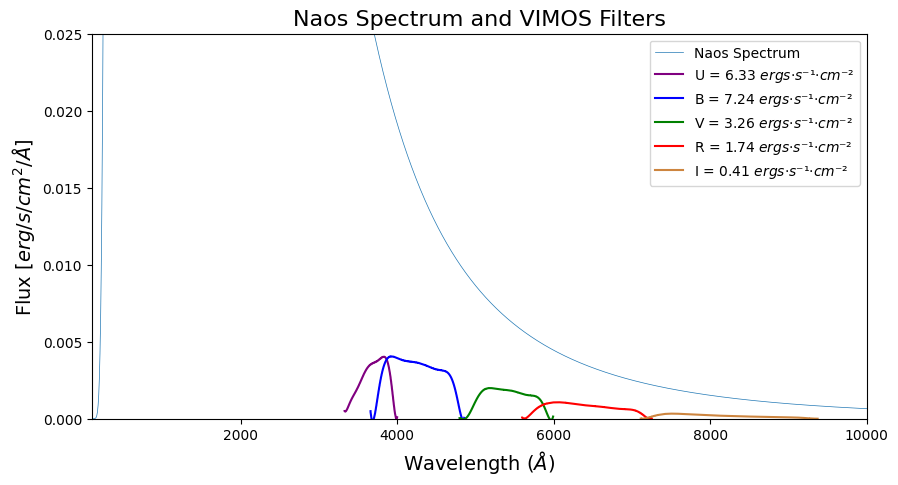

In [780]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(naos_spectrum['Wavelength'], naos_spectrum['Flux'], label=f'Naos Spectrum', linewidth=0.5)
for key, color in zip(naos_filtro, colors):
    ax.plot(naos_filtro[key]['Wavelength'], naos_filtro[key]['Flux solar'], c=color, label=f'{key} = {naos_filtro[key]["Total flux"].values[0]:.2f} $ergs\u00B7s\u207B\u00B9\u00B7cm\u207B\u00B2$')
ax.set_xlim(100, 10000)
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Flux [$erg/s/cm^2/\AA$]', fontsize=14)
ax.set_title('Naos Spectrum and VIMOS Filters', fontsize=16)
ax.set_ylim(0, 0.025)
ax.legend()


### -> Notamos que estas estrellas tienen una temperatura la cual hace que el peak en la longitud de onda sea en el infrarojo para la estrella mira, y en el ultravioleta para las demás estrellas. En los filtros entonces es normal pensar que para la estrella mira el filtro I sea el de mayor flujo adquirido, pero por poca diferencia el filtro R obtiene más flujo. Las otras estrellas en cambio se espera que el filtro U sea el que tenga un mayor índice de flujo, pero el filtro B le supera en cada una de las estrellas. Lo que somos capaces de concluir es que estos filtros no son necesariamente los más útiles a la hora de analizar los espectros de las estrellas cuyo peak de longitud de onda diverga del visible (por ejemplo el sol, cuyo peak cae en el verde), esto debido a que estos filtros están muy concentrados en las longitudes visibles, y además los filtros extremos (U e I) son bastante más pequeños en altura respecto a los demás filtros, haciendo que los flujos captados por los filtros U e I sean menores que el de sus adyacentes a pesar de que los espectros de las estrellas están "cargados" hacia zonas ultravioletas o infrarojas.

# 1.D

In [781]:
def ms(fs, fz):
    return -2.5 * np.log10(fs / fz)

In [782]:
def M_abs(m, d):
    return m - 5 * np.log10(d) + 5

In [783]:
def index_color(zp, fs, d):
    M = []
    for zp, fs in zip(zp, fs):
        Ms = M_abs(ms(fs, zp), d)
        M.append(Ms)
    
    return [M[0] - M[2], M[1] - M[3], M[2] - M[4]]


In [784]:
zpoints = [7.90215e-9, 5.95341e-9, 3.71477e-9, 2.22739e-9, 1.66937e-9]

In [785]:
mira_colors = index_color(zpoints, [mira_filtro['U']['fs'][0], mira_filtro['B']['fs'][0], mira_filtro['V']['fs'][0], mira_filtro['R']['fs'][0], mira_filtro['I']['fs'][0]], 418*u.lightyear.to(u.parsec))
rigel_colors = index_color(zpoints, [rigel_filtro['U']['fs'][0], rigel_filtro['B']['fs'][0], rigel_filtro['V']['fs'][0], rigel_filtro['R']['fs'][0], rigel_filtro['I']['fs'][0]], 860*u.lightyear.to(u.parsec))
saif_colors = index_color(zpoints, [saif_filtro['U']['fs'][0], saif_filtro['B']['fs'][0], saif_filtro['V']['fs'][0], saif_filtro['R']['fs'][0], saif_filtro['I']['fs'][0]], 1300*u.lightyear.to(u.parsec))
naos_colors = index_color(zpoints, [naos_filtro['U']['fs'][0], naos_filtro['B']['fs'][0], naos_filtro['V']['fs'][0], naos_filtro['R']['fs'][0], naos_filtro['I']['fs'][0]], 900*u.lightyear.to(u.parsec))

In [786]:
uv = [mira_colors[0], rigel_colors[0], saif_colors[0], naos_colors[0]]
br = [mira_colors[1], rigel_colors[1], saif_colors[1], naos_colors[1]]
vi = [mira_colors[2], rigel_colors[2], saif_colors[2], naos_colors[2]]

In [787]:
temperaturas = [3000, 11000, 32500, 42000]

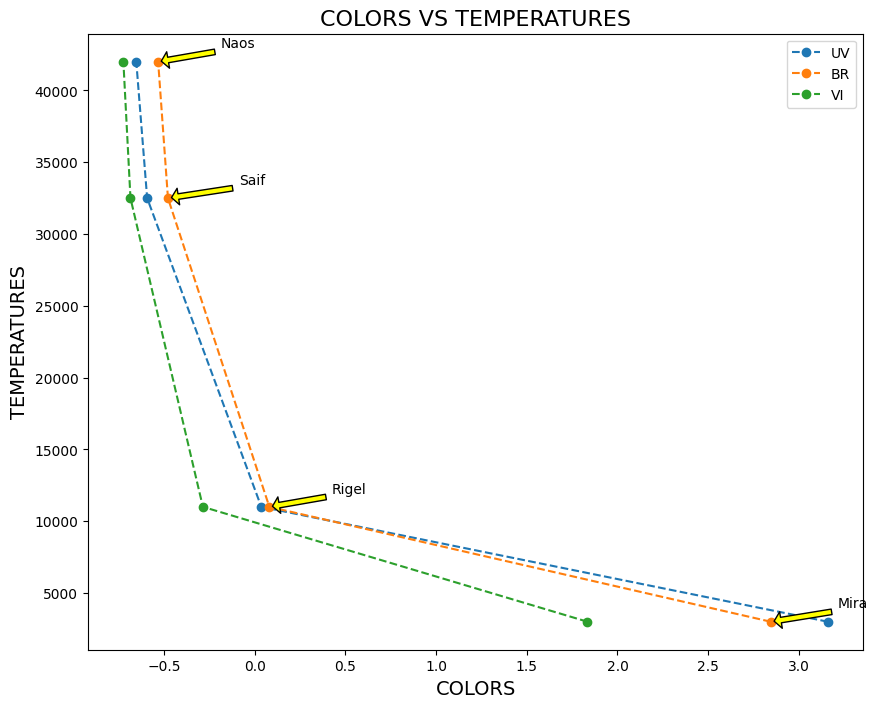

In [789]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(uv, temperaturas, '--o', label='UV')
ax.plot(br, temperaturas, '--o', label='BR')
ax.plot(vi, temperaturas, '--o', label='VI')

for i, txt in enumerate(['Mira', 'Rigel', 'Saif', 'Naos']):
    ax.annotate(txt, (br[i], temperaturas[i]), textcoords="offset points", xytext=(70,10), ha='right', arrowprops=dict(facecolor='yellow', shrink=0.05, headlength=5))
    #ax.annotate(txt, (br[i], temperaturas[i]), textcoords="offset points", xytext=(10,10), ha='center', arrowprops=dict(facecolor='black', shrink=0.05))
    #ax.annotate(txt, (vi[i], temperaturas[i]), textcoords="offset points", xytext=(10,10), ha='center', arrowprops=dict(facecolor='black', shrink=0.05))

ax.set_xlabel('COLORS', fontsize=14)
ax.set_ylabel('TEMPERATURES', fontsize=14)
ax.set_title('COLORS VS TEMPERATURES', fontsize=16)
ax.legend()

# 1.e)

### -> Para  la estrella Mira, son útiles  los filtros R-I, debido que es una estrella fría esta emite su flujo en su mayoría en longitudes de onda en el infrarojo, las últimas estrellas como son mas calientes también se comprueba que emite su peak en rangos de longitud de onda en el ultravioleta, es decir que es apropiado utilizar los filtros U y B,  ya que los rangos de longitud de onda de los filtros son los más cercanos ultravioleta.
